In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

In [68]:
df_coverage_data = pd.read_csv('data/processed_data/coverage_data_processed.csv')

In [ ]:
# get the log for later - to see if we can adjust for heteroscedasticity
df_coverage_data['log_total_cover'] = np.log(df_coverage_data['total_cover'])

In [70]:
print(f"total cover mean: {df_coverage_data['total_cover'].mean()}")
print(f"total cover median: {df_coverage_data['total_cover'].median()}")
print(f"moss cover mean: {df_coverage_data['moss_cover'].mean()}")
print(f"moss cover median: {df_coverage_data['moss_cover'].median()}")
print(f"lichen cover mean: {df_coverage_data['lichen_cover'].mean()}")
print(f"lichen cover median: {df_coverage_data['lichen_cover'].median()}")



total cover mean: 0.2914285714285714
total cover median: 0.23
moss cover mean: 0.06141142857142856
moss cover median: 0.0252
lichen cover mean: 0.23001714285714278
lichen cover median: 0.1541


<Axes: xlabel='total_cover', ylabel='Count'>

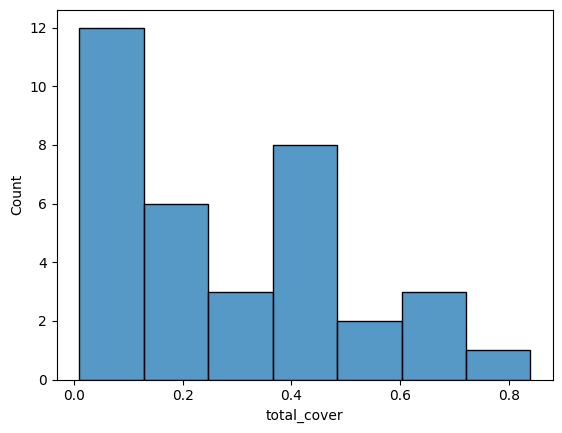

In [71]:
sns.histplot(df_coverage_data['total_cover'])

<Axes: xlabel='moss_cover', ylabel='Count'>

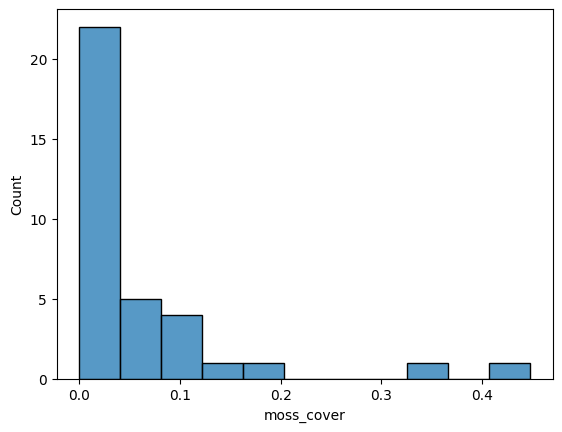

In [72]:
sns.histplot(df_coverage_data['moss_cover'])

<Axes: xlabel='deviation_north', ylabel='Count'>

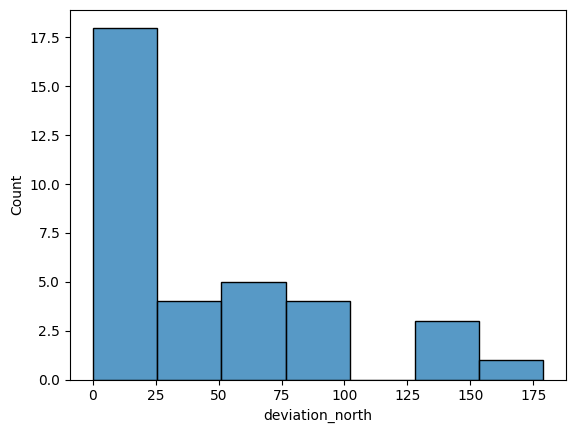

In [73]:
sns.histplot(df_coverage_data['deviation_north'])

<Axes: xlabel='deviation_north', ylabel='total_cover'>

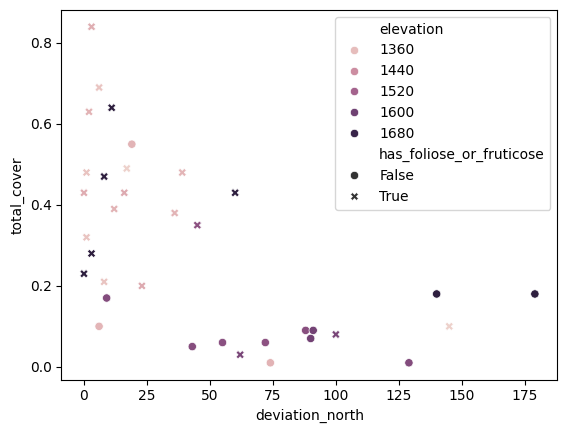

In [74]:
sns.scatterplot(df_coverage_data, x='deviation_north', y='total_cover', style='has_foliose_or_fruticose', hue='elevation')


<Axes: xlabel='deviation_north', ylabel='moss_cover'>

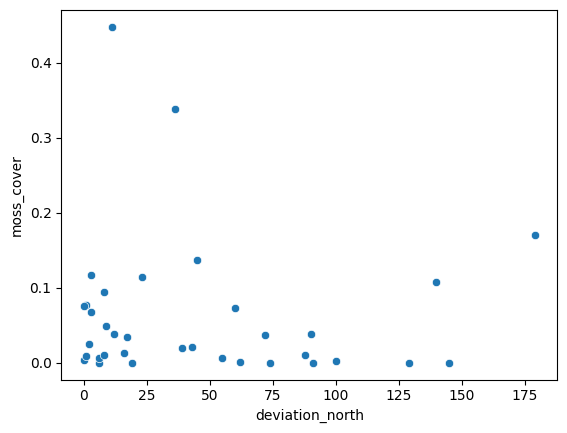

In [75]:
sns.scatterplot(x=df_coverage_data['deviation_north'], y=df_coverage_data['moss_cover'])


<Axes: xlabel='deviation_north', ylabel='lichen_cover'>

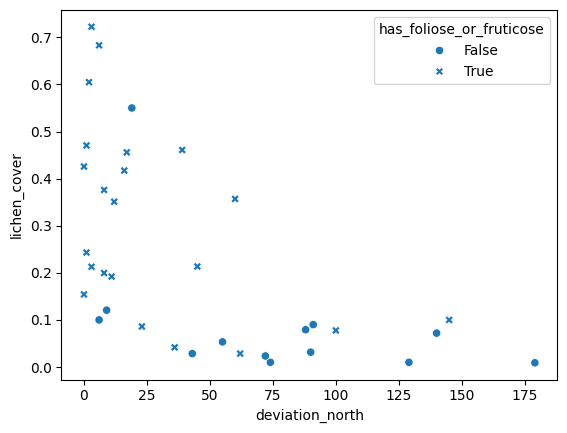

In [76]:
sns.scatterplot(df_coverage_data, x='deviation_north', y='lichen_cover', style='has_foliose_or_fruticose')


<Axes: xlabel='solar_radiation', ylabel='total_cover'>

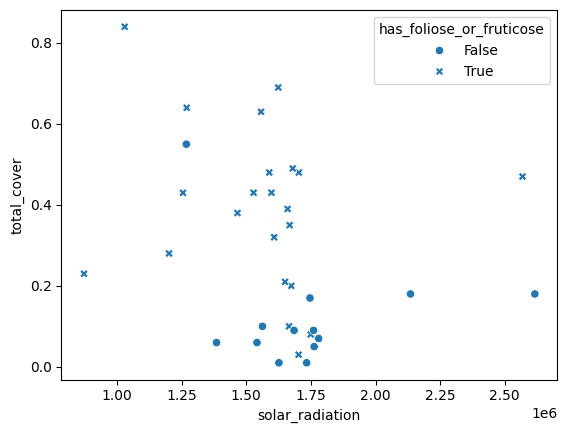

In [77]:
sns.scatterplot(df_coverage_data, x='solar_radiation', y='total_cover', style='has_foliose_or_fruticose')

<Axes: xlabel='elevation', ylabel='total_cover'>

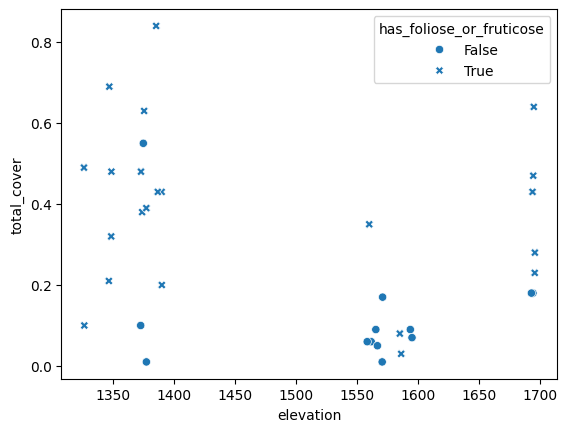

In [78]:
sns.scatterplot(df_coverage_data, x='elevation', y='total_cover', style='has_foliose_or_fruticose')

In [79]:
# I wanna look at data from each lichen species
# get all the columns that have species in them

has_species_columns = ['has_W_f', 'has_GR_c', 'has_Bl_f', 'has_R_c', 'has_Bl_c', 'has_W_fr',
    'has_O_c', 'has_W_c', 'has_Y_f', 'has_G_c']


In [80]:
# get data about the counts of all the species
species_counts = {
        column: df_coverage_data[column].sum() for column in has_species_columns
    }
print(species_counts)


{'has_W_f': np.int64(16), 'has_GR_c': np.int64(8), 'has_Bl_f': np.int64(6), 'has_R_c': np.int64(2), 'has_Bl_c': np.int64(9), 'has_W_fr': np.int64(10), 'has_O_c': np.int64(16), 'has_W_c': np.int64(35), 'has_Y_f': np.int64(1), 'has_G_c': np.int64(33)}


<Axes: >

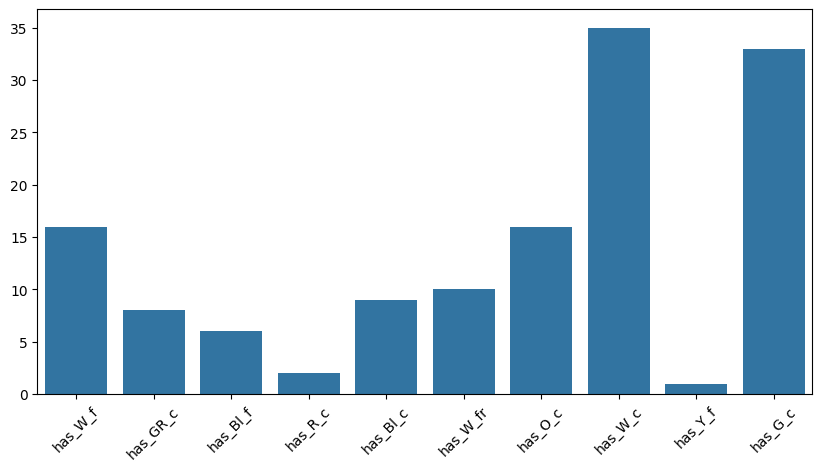

In [81]:
plt.figure(figsize=(10, 5)) 
plt.xticks(rotation=45)
sns.barplot(species_counts)

In [82]:
# variables that I want to run statistical analysis on
vars_of_interest = ['deviation_north', 'solar_radiation']

In [83]:
# run spearman's rank on the variables of interest, x = variable, y = total cover
for variable in vars_of_interest:
    corr, pval = spearmanr(df_coverage_data[variable], df_coverage_data['total_cover'])
    print(f'{variable} and total cover spearmanr values')
    print(f'correlation: {corr}')
    print(f'p value: {pval}')

deviation_north and total cover spearmanr values
correlation: -0.6233438868712187
p value: 6.334873313113461e-05
solar_radiation and total cover spearmanr values
correlation: -0.4187807615519921
p value: 0.012285160574063042


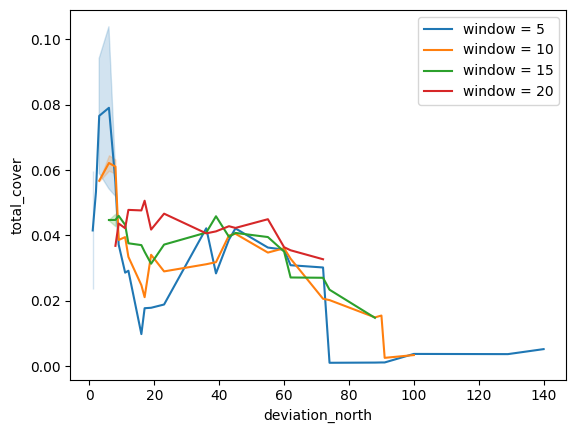

In [84]:
# plotting the variance across aspect deviation from north and total coverage
# get a df where all values for similar deviation_north are near each other
df_by_deviation_north = df_coverage_data.sort_values('deviation_north')
# check how much variance there is for total cover around each
# value of deviation north to see how much the variance itself varies across
# the dataset (= how heteroscedastic the data is)
variance_windows = [5, 10, 15, 20]
# basically: at each "deviation north" value, this checks for the
# 5, 10, 15, or 20 nearest values of corresponding "total cover",
# calculating the variance of these n nearest values. So the graph
# represents various ways to show how much the variance changes across
# the relationship between total cover and aspect deviation from north
for variance_window in variance_windows:
    rol_var = df_by_deviation_north['total_cover'].rolling(
        window=variance_window, center=True
    ).var()
    sns.lineplot(
        df_by_deviation_north, x='deviation_north', y=rol_var,
        label=f'window = {variance_window}'
    )




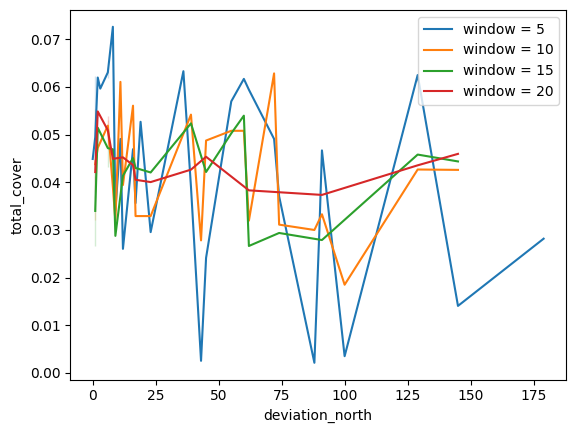

In [85]:
# let's do the same with solar radiation
df_by_solar_radiation = df_coverage_data.sort_values('solar_radiation')

for variance_window in variance_windows:
    rol_var = df_by_solar_radiation['total_cover'].rolling(
        window=variance_window, center=True
    ).var()
    sns.lineplot(
        df_by_solar_radiation, x='deviation_north', y=rol_var,
        label=f'window = {variance_window}'
    )


<Axes: xlabel='deviation_north', ylabel='log_total_cover'>

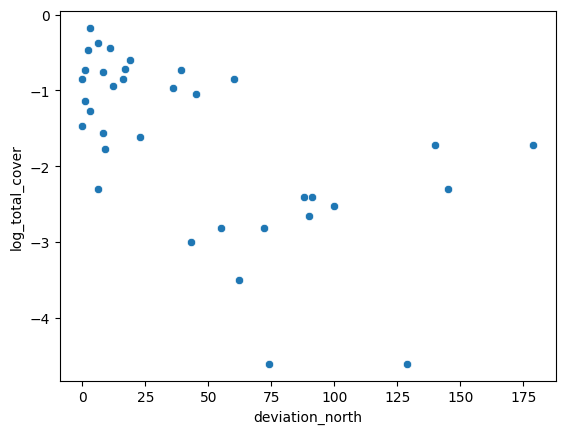

In [86]:
sns.scatterplot(df_coverage_data, x='deviation_north', y='log_total_cover')

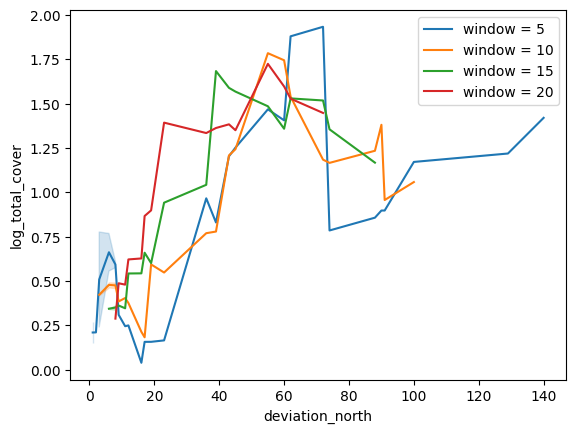

In [87]:
for variance_window in variance_windows:
    rol_var = df_by_deviation_north['log_total_cover'].rolling(
        window=variance_window, center=True
    ).var()
    sns.lineplot(
        df_by_deviation_north, x='deviation_north', y=rol_var,
        label=f'window = {variance_window}'
    )

In [90]:
# numerically check the difference in variance at certain thresholds
from scipy.stats import levene

levene_thresholds = [15, 30, 45, 60]
for threshold in levene_thresholds:
    group1 = df_coverage_data[df_coverage_data['deviation_north'] < threshold]['total_cover']
    group2 = df_coverage_data[df_coverage_data['deviation_north'] >= threshold]['total_cover']
    stat, pval = levene(group1, group2)
    print(f'''how significant is the difference in variance below and above {threshold}
          degrees away from north for total coverage''')
    print(f'f statistic : {stat}')
    print(f'p value: {pval}')

how significant is the difference in variance below and above 15
          degrees away from north for total coverage
f statistic : 0.35864692297242184
p value: 0.5533478219078445
how significant is the difference in variance below and above 30
          degrees away from north for total coverage
f statistic : 1.6746851433211105
p value: 0.20461584423374274
how significant is the difference in variance below and above 45
          degrees away from north for total coverage
f statistic : 4.212722025944606
p value: 0.04812215838029011
how significant is the difference in variance below and above 60
          degrees away from north for total coverage
f statistic : 5.806068156877316
p value: 0.02170896409162583


In [100]:
# let's run a levene test at each "deviation north" value to see how much
# the variance significantly differs at each point

for index, row in df_by_deviation_north.iterrows():
    threshold = row['deviation_north']
    group1 = df_coverage_data[df_coverage_data['deviation_north'] < threshold]['total_cover']
    group2 = df_coverage_data[df_coverage_data['deviation_north'] >= threshold]['total_cover']
    stat, pval = levene(group1, group2)
    df_by_deviation_north.loc[index, 'aspect_levene_pval'] = pval
    df_by_deviation_north.loc[index, 'aspect_levene_fstat'] = stat




/var/folders/gx/kl5k01b91px509w_2wvz4rgr0000gp/T/ipykernel_8842/4216640663.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = levene(group1, group2)
/var/folders/gx/kl5k01b91px509w_2wvz4rgr0000gp/T/ipykernel_8842/4216640663.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = levene(group1, group2)


In [ ]:
sns.lineplot(
    df_by_deviation_north, x='deviation_north', 
    y='aspect_levene_fstat',
    label=f'levene test F statistic value'
)
sig = df_by_deviation_north['aspect_levene_pval'] < 0.05
sns.scatterplot(
    df_by_deviation_north[sig],
    x='deviation_north', y='aspect_levene_fstat',
    color='red', s=20,
    label='levene test p value, only when p < 0.05'
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (526966180.py, line 10)